# EpyMix model

This model is based on a SEIR-like model describing canopy growth and epidemic dynamics. The model consists of two organizational levels: the patch level (~1 m²) representing a small crop canopy unit, and the field level which is a bunch of patches computed in a matrix. 
At the patch level, a canopy is simulated with simple growth functions, representing one given crop, or two crops at a time (i.e. uniform mixture). The difference between crop species is first of all defined by disease susceptibility: a susceptible crop is defined as wheat, while a qualitatively resistant crop is another ‘abstraction’ crop. Within each patch, there is no explicit-spatial structure, but one or two sets of parameters for growth, phenology, planting date and canopy porosity depending on the number of crops. Plant-plant interactions and plant resource dynamics are not modelled. Regarding the epidemic, infection, spore production and spore interception are modelled at the patch level. 
At the field level, the patches are explicitly spatially structured along a matrix. Thereby, the relative crop proportions can be changed at both the patch and the field level. The explicit spatial structure of patches within the field allows to simulate different spatial arrangement. Regarding the epidemic, spore dispersion kernel and gradients are modelled at the field level. The calibration of the spore dispersion kernel determines the scale, such as we wanted that a patch is approximately 1m². 
Time is measured in degree-days (dd) and denoted by t. A cropping season starts at tstart corresponding to the sowing date, ends at tend, corresponding to the harvesting date, and T is the length of the experiment, such that T/tend gives the number of cropping season of the experiment. The inter-cropping season is modelled as an instantaneous projection from tend to the start of the next cropping year. 
The modelled diseases (rust and septoria) are associated with two different set of parameters.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from epymix.rain import rain as _rain 
from epymix.inoculum import inoculum 
from epymix.configuration import configuration
from epymix.SEIR import SEIR 
from epymix.dispersion_gradient import dispersion_kernel_rust, dispersion_kernel_septo
from epymix.growth_companion import growth_pois


## Input Parameters

This set of parameters describe the disease, the time step (in degree-day), the length and number of seasons, the overall length of the experiement and the companion sowing date relatively to the wheat sowing data.


In [2]:
disease = "septo"
delta_t0 = 10 # constant, the model has been parameterise such as t = 10 degree-day
delta_t = 10 # time step
n_season = 1 # number of season
t = n_season*250*int(delta_t0/delta_t) # length of the experiment
season = 250*int(delta_t0/delta_t)  # 2500 dd %% length of a cropping season
delta_companion = 0 # growth start lag of the companion crop (dd), negative: companion before, positive: companion after but for i<delta Poi=0


## Spatial arrangement scenario
$L_x$, $L_y$, $L_r$

These function and associated parameters set the size of the field and the spatial arrangement scenario. This function determines if one patch or a field (more than one patch) is modelled.

In [3]:
Lr=Lx=Ly=1 
scenario_rot='uniform'
wheat_fraction=0.5

arrangement = configuration(Lr, Lx, Ly, scenario_rot, wheat_fraction)

## GROWTH PARAMETERS


These parameters and function describe the growth and spore interception capacity of the two crops (wheat and companion). There is an isolated growth function for the companion (growth_pois). 

In [4]:
mu_wheat = 0.03 * delta_t / delta_t0  # 0.03 %% mortality rate of S and E tissues (LAI/10dd)
nu = 0.03 * delta_t / delta_t0  # nu = mu %% mortality of I infectious tissues (LAI/10dd)
mu_companion = 0.03 * delta_t / delta_t0  # 0.03 %% mortality rate of the companion species (LAI/10dd)
beta_wheat = 0.09 * delta_t / delta_t0  # 0.09 %% wheat growth parameter (LAI/10dd)
beta_companion = 0.09 * delta_t / delta_t0  # beta_companion = beta_wheat %% growth parameter of the companion crop (LAI/10dd)
end_wheat = 140 * int(delta_t0 / delta_t)  # 1400 dj %% date of wheat growth end
end_companion = 140 * int(delta_t0 / delta_t)  # end_companion = end_wheat %% date of growth end for the companion crop
LAI_K = 6  # 6 %% carrying capacity (Maximum canopy LAI)
ber_wheat = 1  # 1 # wheat spore interception coefficient (the Beer-Lambert law)
ber_companion = 1  # 1 # spore interception coefficient of the companion species (the Beer-Lambert law)
h_wheat = 1  # wheat height
h_companion = 1  # companion height

Pth_inde, Poi_inde = growth_pois(t=t, season=season, arrangement=arrangement,
                       mu_companion=mu_companion, beta_companion=beta_companion, end_companion=end_companion, LAI_K=LAI_K)


## E-I TRANSITION PARAMETERS
$\delta_{ei}$ : transition

$\lambda$ : latent duration

These parameters describe the latent period in the SEIR model and drive the transition from latent to infectious states. 

In [5]:
delta_ei = 5*int(delta_t0/delta_t)
lambd = 20*int(delta_t0/delta_t) # 200 dd %% latent duration


## EPIDEMIC PARAMETERS

The parameters describe the epidemiology of the disease (lesion size, probability of spore infection, spore mortality, virulence, spore production rate, epidemic start). There are two sets of parameters for the two modelled diseases respectively (rust and septoria).

In [6]:
s0 = 0.0001 # 0.0001 %% lesion size (µm²)
pi_inf0 = 0.0002 # 0.0002 %% spore probability infection
rho = 0.002*delta_t/delta_t0  # 0.01 %% spore mortality in P reservoir
psi = 0.3  # 0.3 %% pycnide emptying rate by rain (only for septoriose)
gamma = 0  # 0 %% virulence parameter
theta = 0.15  # 0.015 %% spore intercropping survival rate
sigma = 45000000  # 50000000 %% spore production rate (septo: pycnidiospores by rain)
sigma_asco = 0.2 * sigma # 0.2*sigma %% (parameter for septoriose only, ascospores by wind)
inf_begin = 0*int(delta_t0/delta_t)  #  1000 dd %% date of epidemic start (generally between 80 et 130 dd for rust)


### RAIN PARAMETER

These parameters describe frequency of rain events mased on meteorological data. This is relevant only for septoria.

In [7]:
years = np.arange(2000,2000+n_season,1) #1995: bad; 1997: medium, 2000: good
years = years.tolist()
rain = _rain(years, delta_t)

### INOCULUM PARAMETERS

These parameters is for (i) initialization of simulations based on the quantity and location of primary spores (initial inoxulum) and (ii) the external spore cloud intensity during a cropping season.

In [8]:
scenario_ino = 'initial_inoculum' # scenario_ino: which scenario of initial inoculum (chose: central_focus, initial_inoculum, annual_cloud)
frac_inf = 1 # frac_inf: fraction of patches within the field inoculated
inoc_init_abs = 20000000 # inoc_init_abs: initial inoculum intensity
ng_ext0_abs = int(20000*delta_t/delta_t0) # ng_ext0_abs: external cloud intensity
inoc_init, ng_ext0 = inoculum(scenario_ino, Lx, Ly, frac_inf, inoc_init_abs, ng_ext0_abs)


### SPORE DISPERSION

This set of parameters and the associated function describe the spore spatial dispersion between patches, i.e. within a field. This function is not used when only one patch is modelled.

In [9]:
day_length = (24/(2*delta_t))*60*60
alpha_asco = 3 # coefficient of dispersal (n m-1;Fitt et al 1987)
radius_asco = 5
alpha_pycnid = 0.2 * 0.0001 # coefficient of dispersal (m² s-1; Yang et al 1991)
radius_pycnid = 5
alpha_ure = 3
radius_ure = 5

kernel_asco, C_Disp_asco, kernel_pycnid, C_Disp_pycnid = dispersion_kernel_septo(day_length, alpha_asco, radius_asco, alpha_pycnid, radius_pycnid)
kernel_ure, C_Disp_ure = dispersion_kernel_rust(day_length, alpha_ure, radius_ure)


### SEIR FUNCTION

This is the core SEIR function of the model, generating the main outputs such as LAI or AUDPC. Outputs are nmubers (one patch) or matrices (several patches, i.e. a field).

In [10]:
Nsp, Pth, Poi, Sth, Sus, Lat, Ifc, Ifv, Rem, LAI, LAI_wheat, Poo, Eps, AUDPC, Scont = SEIR(
    t=t, 
    delta_t0=delta_t0, delta_t=delta_t, 
    season=season, delta_companion=delta_companion,
    disease=disease, rain=rain, arrangement=arrangement, inoc_init=inoc_init, ng_ext0=ng_ext0,
    mu_wheat=mu_wheat, nu=nu, beta_wheat=beta_wheat, #beta_companion=beta_companion, end_companion=end_companion
    end_wheat=end_wheat, LAI_K=LAI_K, ber_wheat=ber_wheat, ber_companion=ber_companion, Pth_inde=Pth_inde, Poi_inde=Poi_inde,
    h_wheat=h_wheat, h_companion=h_companion,
    lambd=lambd, delta_ei=delta_ei,
    s0=s0,pi_inf0=pi_inf0, rho=rho, psi=psi, gamma=gamma, theta=theta, sigma=sigma, sigma_asco=sigma_asco, inf_begin=inf_begin,
    C_Disp_ure=C_Disp_ure, kernel_ure=kernel_ure, C_Disp_asco=C_Disp_asco, kernel_asco=kernel_asco,
    C_Disp_pycnid=C_Disp_pycnid, kernel_pycnid=kernel_pycnid)


In [11]:
T = [*range(0,t)]
Sth = np.mean(Sth, axis=(1,2))
Pth = np.mean(Pth, axis=(1,2))
Poi = np.mean(Poi, axis=(1,2))
Lat = np.mean(Lat, axis=(1,2))
Ifc = np.mean(Ifc, axis=(1,2))
Ifv = np.mean(Ifv, axis=(1,2))
Sus = np.mean(Sus, axis=(1,2))
Rem = np.mean(Rem, axis=(1,2))
Nsp = np.mean(Nsp, axis=(1,2))
LAI = np.mean(LAI, axis=(1,2))
LAI_wheat = np.mean(LAI_wheat, axis=(1,2))
Poo = np.mean(Poo, axis=(1,2))
AUDPC = np.mean(AUDPC, axis=(1,2))
Eps = np.mean(Eps, axis=(1,2))
Scont = np.mean(Scont, axis=(1,2))


In [12]:
%matplotlib inline

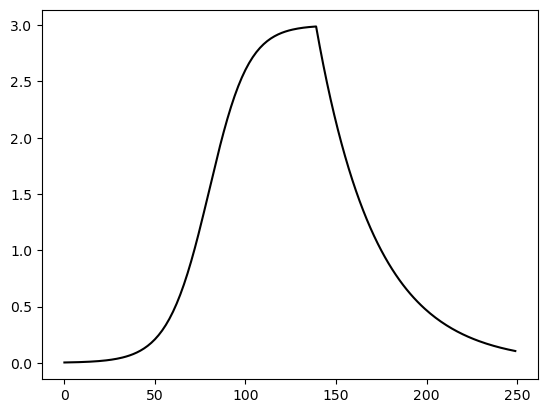

In [13]:
plt.plot(T, Sth, color='black')

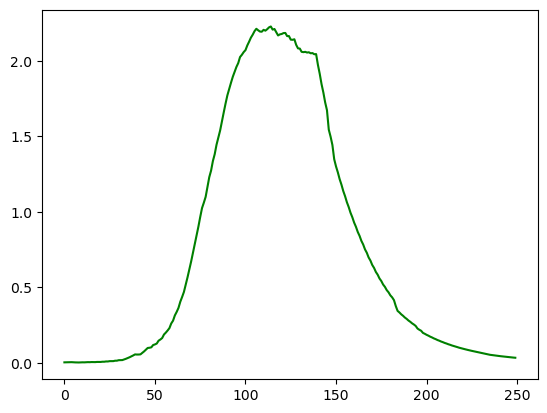

In [14]:
plt.plot(T, Sus, color='green')

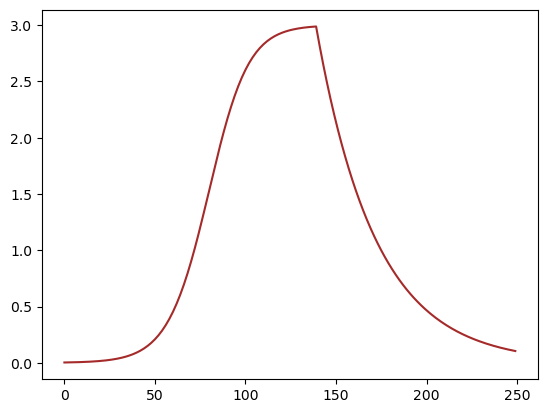

In [15]:
plt.plot(T, Poi, color='brown')

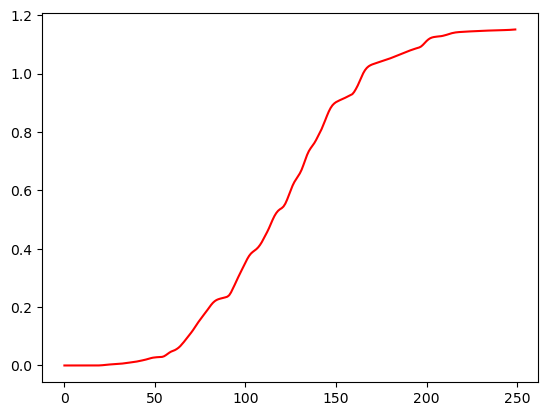

In [16]:
plt.plot(T, Ifv, color='red')

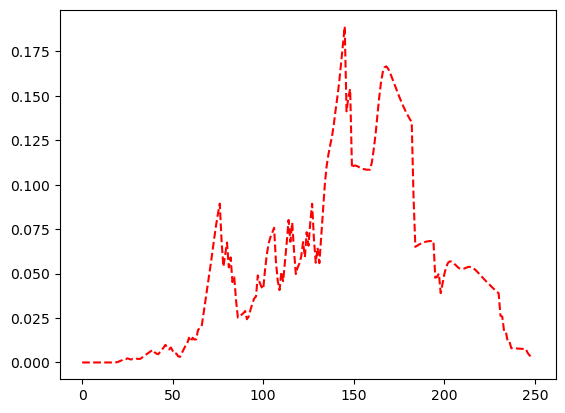

In [17]:
plt.plot(T, Ifc, color='red',linestyle="--")